In [1]:
ls ../dnftresult

OneDCyclic_mlp1layer_nonDim_baseline/
OneDsignal_c8mimic_fordebug_baseline/
OneDsignal_c8mimic_mask1Stacklayer_baseline/
OneDsignal_c8mimic_mask1layer_baseline/
OneDsignal_fordebug_baseline/
OneDsignal_mask1layer_baseline/
OneDsignal_mlp1layer_Dimside_baseline/
OneDsignal_mlp1layer_baseline/
OneDsignal_mlp1layer_nonDim_baseline/


In [2]:
import sys
import yaml
sys.path.append('../')
import os
import torch
from misc import yaml_util as yu
sys.path.append('../dataset')
sys.path.append('../module')
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca


In [11]:
datname = 'OneDsignal_c8mimic'
#datname = 'OneDCyclic'
modelname = 'mask1Stacklayer'
#modelname = 'mlp1layer_nonDim'
#modelname = 'mask1layer'

trainname = 'baseline'
with open(f'''../cfg_data/{datname}.yaml''', 'rb') as f:
    cfg_data = yaml.safe_load(f)

cfg_data['args']['shift_label'] = True
mydata = yu.load_component(cfg_data) 

myloader = DataLoader(mydata, batch_size=20,
                        shuffle=True, 
                        num_workers=1,
                        )


seq, shift =  mydata[0]
seq = seq[None, :]
print(seq.shape)

expname = f'''{datname}_{modelname}_{trainname}'''

exppath = os.path.join("../dnftresult", expname)
if not os.path.exists(exppath):
    raise NotImplementedError
mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)
mymodel = mymodel.to(0)
mymodel

./dataset/oneDsignal_data.py
[1, 8, 16, 32, 56]
0
torch.Size([1, 3, 128])


DFNFT(
  (owndecoders): ModuleList(
    (0): MLPDecoder(
      (activation_fxn): Tanh()
      (net): Sequential(
        (0): MaskFlatLinear()
        (1): Tanh()
        (2): MaskFlatLinear()
        (3): Tanh()
        (4): MaskFlatLinear()
        (5): Linear(in_features=130, out_features=128, bias=True)
      )
    )
  )
  (nftlayers): ModuleList(
    (0): NFT(
      (encoder): MLPEncoder(
        (activation_fxn): Tanh()
        (net): Sequential(
          (0): Linear(in_features=128, out_features=130, bias=True)
          (1): MaskFlatLinear()
          (2): Tanh()
          (3): MaskFlatLinear()
          (4): Tanh()
          (5): MaskFlatLinear()
        )
      )
      (decoder): MLPDecoder(
        (activation_fxn): Tanh()
        (net): Sequential(
          (0): MaskFlatLinear()
          (1): Tanh()
          (2): MaskFlatLinear()
          (3): Tanh()
          (4): MaskFlatLinear()
          (5): Linear(in_features=130, out_features=128, bias=True)
        )
      )
  

In [8]:
Ms = []
shifts = [] 
for k in range(100):
    evalseq, shift = next(iter(myloader))
    evalseq = evalseq[:, :2].to(mymodel.nftlayers[0].encoder.device)
    predicted = mymodel(evalseq, n_rolls=1)
    shifts.append(shift)
    Ms.append(mymodel.nftlayers[-1].dynamics.M) 
    
shifts = torch.concatenate(shifts)
Ms = torch.concatenate(Ms)

In [9]:
from importlib import reload
reload(ca)
targfreq, prods = ca.inner_prod(Ms, shifts, maxfreq=64, bins=65)

100%|██████████| 65/65 [00:23<00:00,  2.74it/s]


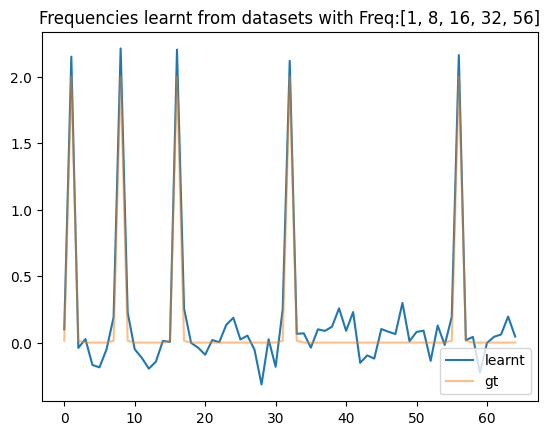

In [10]:
plt.figure()
plt.plot(targfreq, prods, label='learnt')
deltas = ca.deltafxn(targfreq, mydata.freqsel)*2
plt.plot(targfreq, deltas, label='gt',alpha=0.5)

plt.title(f"""Frequencies learnt from datasets with Freq:{mydata.freqsel}""")
plt.legend()